### 0. lib and file load 

In [42]:
import pandas as pd
import numpy as np 

# 시각화 
import matplotlib.pyplot as plt

# 모델링
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from pmdarima.arima import ndiffs
import pmdarima as pm

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

# 평가
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
# 파일을 불러오고 저장할 경로 설정

save_path = '/home/ubuntu2/workspace/JYK/kcit/data/preprocessed'

# 데이터 로드 

train = pd.read_parquet(f'{save_path}/train.parquet')
test = pd.read_parquet(f'{save_path}/test.parquet')
valid = pd.read_parquet(f'{save_path}/valid.parquet')

In [3]:
# 시각화 전 한글 깨짐 방지

plt.rcParams['font.family'] = 'NanumGothic'

In [4]:
target = '수위(mm)'

# ARIMA 모델은 다른 feature를 필요로 하지 않으므로 target인 수위 피처만을 학습 데이터로 추출 

y_train = train[target]
y_test = test[target]
y_valid = valid[target]

In [5]:
y_test

날짜 및 시간
2022-04-30 23:50:00    27.5
2022-04-30 23:40:00    27.3
2022-04-30 23:30:00    27.1
2022-04-30 23:20:00    26.9
2022-04-30 23:10:00    26.7
                       ... 
2022-02-01 00:40:00    30.4
2022-02-01 00:30:00    22.1
2022-02-01 00:20:00    15.4
2022-02-01 00:10:00     7.8
2022-02-01 00:00:00     0.0
Name: 수위(mm), Length: 12808, dtype: float64

<AxesSubplot: xlabel='날짜 및 시간'>

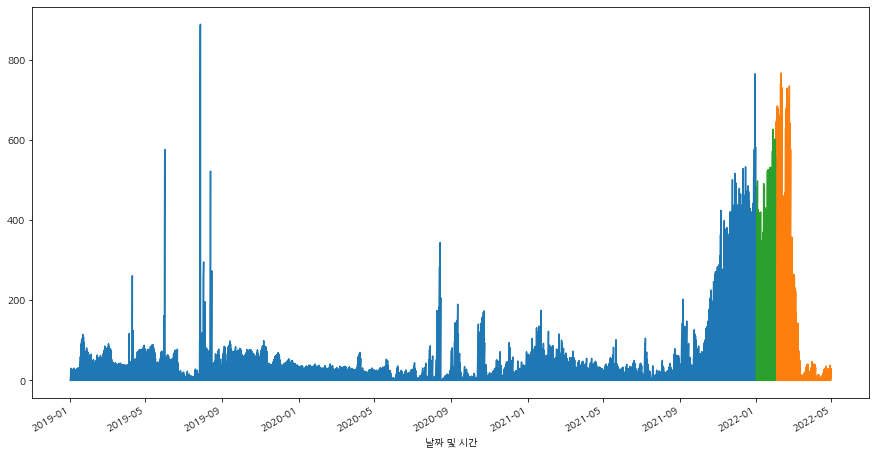

In [26]:
# 시각화를 통해 데이터의 개형 재확인 

fig, axes = plt.subplots(1, 1, figsize=(15, 8))
y_train.plot()
y_test.plot()
y_valid.plot()

### 1. modeling

In [60]:
# 차분이 필요한지 확인

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d={n_diffs}")

추정된 차수 d=1


In [ ]:
model = pm.auto_arima(y=y_train, 
                      d=1, 
                      start_p=2, 
                      max_p=5, 
                      start_q=2, 
                      max_q=5, 
                      m=1, # m=1이면 일별 데이터로 파악 -> 계절성이 없다고 가정, 자동으로 seasonal=False
                      stepwise = True,
                      trace=True)
model.fit(y_train)

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               157682
Model:               SARIMAX(0, 1, 5)   Log Likelihood             -592592.291
Date:                Tue, 27 Dec 2022   AIC                        1185196.583
Time:                        09:42:58   BIC                        1185256.393
Sample:                             0   HQIC                       1185214.370
                             - 157682                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0140      0.006     -2.347      0.019      -0.026      -0.002
ma.L2         -0.0157      0.006     -2.683      0.007      -0.027      -0.004
ma.L3         -0.0168      0.006     -2.900      0.0

/home/ubuntu2/anaconda3/envs/kcit-ext/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


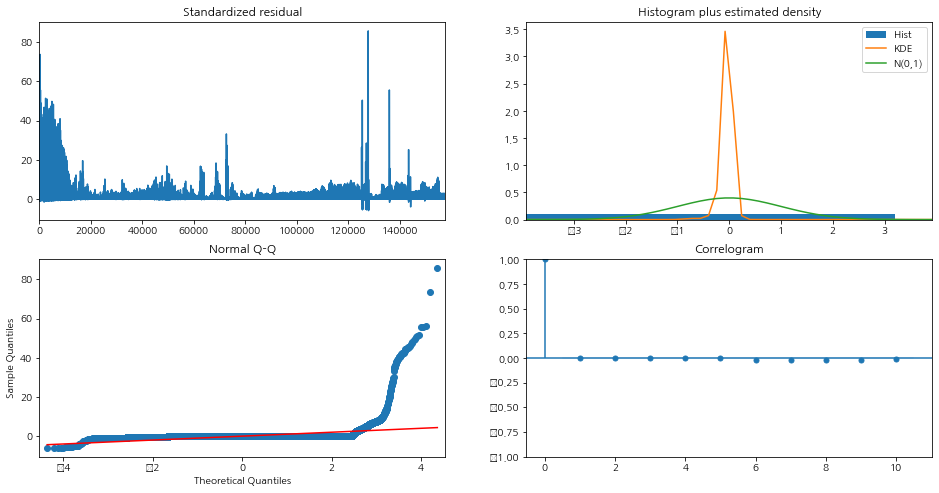

In [ ]:
# 잔차의 백색잡음 여부와 정규성을 따르는지의 여부 확인

model.plot_diagnostics(figsize=(16, 8))
plt.show()

In [62]:
y_pred = model.predict(n_periods=len(y_test)) 

/home/ubuntu2/anaconda3/envs/kcit-ext/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [132]:
# 모델을 단계적으로 수정

def forecast_one_step():
    fc, conf_int = model.predict(1, return_conf_int=True)
    
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

# 테스트 데이터를 하나씩 업데이트함: 임의로 앞 1000개를 투입 

for new_ob in y_test[:1000]:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    
    model.update(new_ob)

### 3. 평가

In [137]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 테스트 데이터------------------------------------------------------
    go.Scatter(x=y_test[:1000].index, y=y_test[:1000], name="Test", mode='lines',
                line=dict(color='rgba(0,0,30,0.5)')),
    # 예측값-----------------------------------------------------------
    go.Scatter(x=y_test[:1000].index, y=y_pred, name="Prediction", mode='lines'
                     ,line=dict(color='red', dash='dot', width=3)),
    
    # 신뢰 구간---------------------------------------------------------
    go.Scatter(x=y_test[:1000].index.tolist() + y_test[:1000].index[::-1].tolist(),
                y=pred_upper + pred_lower[::-1], ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                fill='toself',
                fillcolor='rgba(0,0,30,0.1)',
                line=dict(color='rgba(0,0,0,0)'),
                hoverinfo="skip",
                showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA 모형")
fig.show()

In [138]:
mae = mean_absolute_error(y_test[:1000], y_pred)
mape = mean_absolute_percentage_error(y_test[:1000], y_pred)
rmse = np.sqrt(mean_squared_error(y_test[:1000], y_pred))

print(f'MAE: {mae:.3f}, MAPE: {mape:.3f}, RMSE: {rmse:.3f}')

MAE: 0.331, MAPE: 5047072868476.328, RMSE: 2.094
